In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import gensim
from gensim import corpora, models
from numpy import mean
from numpy import std
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import ClassifierChain

RuntimeError: Compiled extensions are unavailable. If you've installed from a package, ask the package maintainer to include compiled extensions. If you're building Gensim from source yourself, install Cython and a C compiler, and then run `python setup.py build_ext --inplace` to retry. 

# Data and Notebook Setup

In [22]:
df = pd.read_csv('IMA_recommendation_simulation_data.csv')

In [3]:
print("Length: ",len(df))
size = df.size
shape = df.shape
print("Size of DataSet: ", size)
print("Shape of DataSet: ", shape)
print("List of Data types:\n", df.dtypes)

Length:  161563
Size of DataSet:  2585008
Shape of DataSet:  (161563, 16)
List of Data types:
 Unnamed: 0                int64
request_id               object
week_id                   int64
weekday                  object
miles                     int64
order_equipment_type     object
order_distance          float64
order_num_stops           int64
order_origin_weight     float64
lead_days                 int64
color                    object
origin_dat_ref            int64
dest_dat_ref              int64
rate_norm               float64
est_cost_norm           float64
CurrentCondition         object
dtype: object


The shape of this dataset is (161563, 16), and there are 7 unique Condition categories.

In [4]:
print("Number of Condition Categories: ", df['CurrentCondition'].value_counts().count())

Number of Condition Categories:  7


# Exploratory Data Analysis

In [7]:
print("Missingness: \n", df.isnull().sum())

Missingness: 
 Unnamed: 0                 0
request_id                 0
week_id                    0
weekday                    0
miles                      0
order_equipment_type       0
order_distance          4678
order_num_stops            0
order_origin_weight       19
lead_days                  0
color                      0
origin_dat_ref             0
dest_dat_ref               0
rate_norm                181
est_cost_norm             39
CurrentCondition         118
dtype: int64


The following columns have missing data: order_distance, order_origin_weight, rate_norm, est_cost_norm, and CurrentCondtion. The request ID is unique because it is a type object. 

In [8]:
df.corr(method='pearson')

,Unnamed: 0,week_id,miles,order_distance,order_num_stops,order_origin_weight,lead_days,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm
Unnamed: 0,1.000000,-0.000418,-0.002983,-0.002669,-0.002841,-0.001675,0.003856,-0.004255,-0.005856,-0.001472,-0.002496
week_id,-0.000418,1.000000,-0.019201,-0.019802,-0.009899,-0.000422,0.007609,-0.001539,-0.010358,0.022749,-0.036973
miles,-0.002983,-0.019201,1.000000,0.982291,0.057819,-0.012212,0.025197,0.069189,0.248031,0.697896,0.742555
order_distance,-0.002669,-0.019802,0.982291,1.000000,NaN,-0.009852,0.027990,0.066862,0.246584,0.689225,0.730472
order_num_stops,-0.002841,-0.009899,0.057819,NaN,1.000000,-0.025359,0.037197,0.004474,-0.004028,0.061158,0.108425
order_origin_weight,-0.001675,-0.000422,-0.012212,-0.009852,-0.025359,1.000000,0.009731,-0.004263,-0.003545,-0.010642,-0.013850
lead_days,0.003856,0.007609,0.025197,0.027990,0.037197,0.009731,1.000000,0.017822,-0.004046,-0.005291,-0.003025
origin_dat_ref,-0.004255,-0.001539,0.069189,0.066862,0.004474,-0.004263,0.017822,1.000000,0.623976,-0.000007,-0.000004
dest_dat_ref,-0.005856,-0.010358,0.248031,0.246584,-0.004028,-0.003545,-0.004046,0.623976,1.000000,0.061579,0.048371
rate_norm,-0.001472,0.022749,0.697896,0.689225,0.061158,-0.010642,-0.005291,-0.000007,0.061579,1.000000,0.803012


In [9]:
df.corr().unstack().sort_values(ascending = False).drop_duplicates()

est_cost_norm        est_cost_norm          1.000000
order_distance       miles                  0.982291
est_cost_norm        rate_norm              0.803012
miles                est_cost_norm          0.742555
order_distance       est_cost_norm          0.730472
rate_norm            miles                  0.697896
                     order_distance         0.689225
origin_dat_ref       dest_dat_ref           0.623976
dest_dat_ref         miles                  0.248031
order_distance       dest_dat_ref           0.246584
est_cost_norm        order_num_stops        0.108425
miles                origin_dat_ref         0.069189
origin_dat_ref       order_distance         0.066862
rate_norm            dest_dat_ref           0.061579
                     order_num_stops        0.061158
miles                order_num_stops        0.057819
est_cost_norm        dest_dat_ref           0.048371
lead_days            order_num_stops        0.037197
order_distance       lead_days              0.

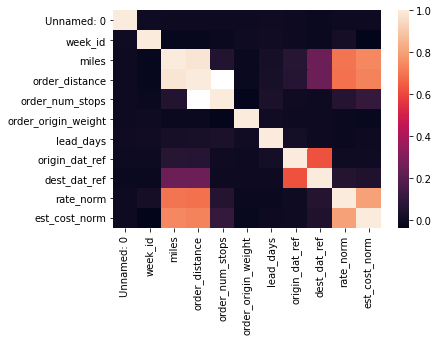

In [10]:
sn.heatmap(df.corr())

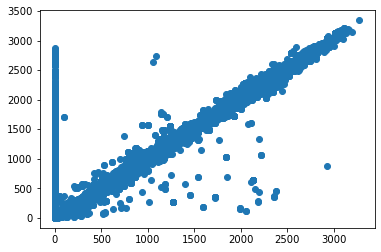

In [11]:
plt.scatter(df.order_distance, df.miles)
plt.show()

This scatterplot of order distance plotted against miles, shows an obvious positive relationship. There is a steady incline, showing that as the order distance increases, the miles increase at about the same rate. This would make sense seeing that there is a very large correlation value of 0.982291.

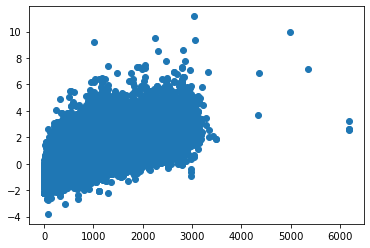

In [14]:
plt.scatter(df.miles, df.est_cost_norm)
plt.show()

This scatterplot of miles plotted against estimated cost (normalized), shows a steep positive relationship. There is a large incline, showing that as the miles increase, normalized estimated cost increases at a very rapid rate. The correlation value of 0.742555 shows that these variables overlap much more than others.

Accepted                     0.595652
Rejected                     0.230066
Withdrawn                    0.147419
Cancelled                    0.020985
Waiting On Acceptance        0.004955
Waiting On Recommendation    0.000588
NoPace                       0.000334
Name: CurrentCondition, dtype: float64


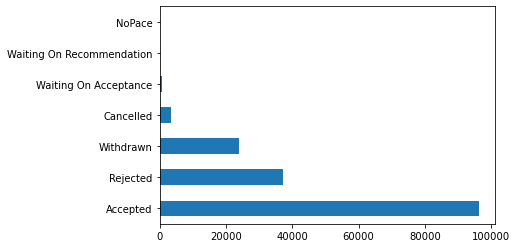

In [13]:
print(df.CurrentCondition.value_counts(normalize = True))
df.CurrentCondition.value_counts().plot.barh()
plt.show()

This bar graph visualization shows how many orders are in each category of Current Condition. From the bars, we can see that most orders are Accepted, with Rejected being the second most likely. 

color                         GREEN       RED    YELLOW
CurrentCondition                                       
Accepted                  -0.055813  0.028103 -0.275174
Cancelled                 -0.047069  0.093151 -0.204492
NoPace                     0.505071  0.011378       NaN
Rejected                  -0.068765  0.161603 -0.324283
Waiting On Acceptance     -0.446668  0.319869 -0.219705
Waiting On Recommendation -0.407833  0.256496 -0.462497
Withdrawn                 -0.095235  0.082747 -0.311773


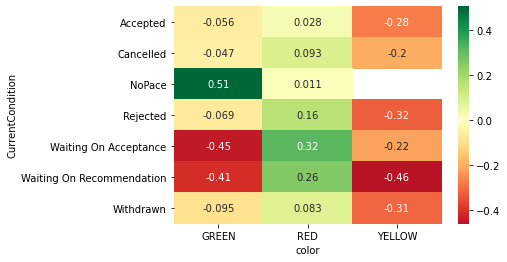

In [19]:
result = pd.pivot_table(data=df, index='CurrentCondition', columns='color',values='est_cost_norm')
print(result)
sn.heatmap(result, annot=True, cmap = 'RdYlGn', center=0)
plt.show()

This visualization gives a table as well as a heat map to explain what is going on. The boxes with darker red show that there is a lower estimated cost, while those with the green are at a higher estimated cost. The boxes themselves are fit to be in a category of the Current Condition and a category of the color given as well. 

# Classification Model 

In [23]:
df = df.drop('request_id', axis=1)
df = df.iloc[: , 1:]

In [24]:
df = df[df['CurrentCondition'].notna()]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
categ = ['order_equipment_type', 'weekday', 'CurrentCondition', 'color']
df[categ] = df[categ].apply(le.fit_transform)

#### Processing the data with imputation

In [25]:
df['order_origin_weight'].fillna(df['order_origin_weight'].mean(), inplace = True)
df['rate_norm'].fillna(df['rate_norm'].mean(), inplace = True)
df['est_cost_norm'].fillna(df['est_cost_norm'].mean(), inplace = True)
df['order_distance'].fillna(df['order_distance'].mean(), inplace = True)

In [26]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

#### Train and Test sets

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

#### Decision Tree Classifier

In [28]:
from sklearn import tree 
variables = df.iloc[:,:-1]
results = df.iloc[:,-1]

decision_tree = tree.DecisionTreeClassifier().fit(X_train, y_train)
tree_predictions = decision_tree.predict(X_test)
tree_expected = y_test

In [29]:
matches = (tree_predictions == tree_expected)
print("Correct Matches:", matches.sum())
print("Data Points:", len(matches))
print("Accuracy Rate:", matches.sum() / float(len(matches)))

Correct Matches: 28550
Data Points: 40362
Accuracy Rate: 0.7073484961102027


In [30]:
from sklearn import metrics
print(metrics.classification_report(tree_predictions,tree_expected))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80     23646
           1       0.36      0.34      0.35       919
           2       0.19      0.16      0.17        19
           3       0.64      0.64      0.64      9293
           4       0.45      0.40      0.43       200
           5       0.09      0.07      0.08        28
           6       0.52      0.50      0.51      6257

    accuracy                           0.71     40362
   macro avg       0.43      0.42      0.42     40362
weighted avg       0.70      0.71      0.71     40362



In [31]:
print(metrics.confusion_matrix(tree_predictions,tree_expected))
plt.show()

[[19100   281     7  2293    51     5  1909]
 [  328   311     0   163     0     0   117]
 [    5     0     3     3     2     0     6]
 [ 2308   174     2  5956    26     0   827]
 [   50     8     0    41    80     0    21]
 [    4     0     0     5     0     2    17]
 [ 2145    90     4   887    17    16  3098]]


In [32]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(decision_tree, X_test, y_test)
tree_values= imps.importances_mean
print(tree_values)

[0.03221842 0.01704078 0.09363758 0.0153263  0.06973391 0.00127348
 0.14380358 0.06235568 0.13216392 0.17418364 0.0847183  0.101105
 0.06956048]


In [33]:
names = list(df)
del names[-1]

In [34]:
data = {'names': names, 'values': tree_values}
Table_tree = pd.DataFrame(data=data)
print(Table_tree.sort_values(by='values', ascending=False))

                   names    values
9         origin_dat_ref  0.174184
6    order_origin_weight  0.143804
8                  color  0.132164
11             rate_norm  0.101105
2                  miles  0.093638
10          dest_dat_ref  0.084718
4         order_distance  0.069734
12         est_cost_norm  0.069560
7              lead_days  0.062356
0                week_id  0.032218
1                weekday  0.017041
3   order_equipment_type  0.015326
5        order_num_stops  0.001273


Text(0, 0.5, '')

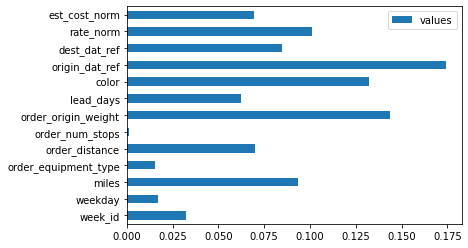

In [35]:
ax = Table_tree.plot.barh(x='names', y='values')
ax.set_ylabel(None)

In [51]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(decision_tree, X, y, cv=3))

[0.70225773 0.70153303 0.701979  ]


This classification model is better to produce the Current Condition of a load. The model would place the load correctly  70.73% of the time. This is a decent way to predict a load. The geographic region and weight of the shipment are the best features of this model. The graph above explains the features with the most importance as having the highest bar graph. This model is slightly overfit, seeing that there are different mean scores.

#### Gaussian Naive Bayes Model

In [36]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
gnb_expected = y_test

In [37]:
matches = (gnb_predictions == gnb_expected)
print("Correct Matches:", matches.sum())
print("Data Points:", len(matches))
print("Accuracy Rate:", matches.sum() / float(len(matches)))

Correct Matches: 21686
Data Points: 40362
Accuracy Rate: 0.537287547693375


In [38]:
from sklearn import metrics
print(metrics.classification_report(gnb_predictions,gnb_expected))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69     27534
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00       104
           3       0.42      0.31      0.36     12569
           4       0.01      0.01      0.01       146
           5       0.00      0.00      0.00         0
           6       0.00      0.11      0.00         9

    accuracy                           0.54     40362
   macro avg       0.17      0.15      0.15     40362
weighted avg       0.64      0.54      0.58     40362



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
print(metrics.confusion_matrix(gnb_predictions,gnb_expected))
plt.show()

[[17761   688     9  5400   110    13  3553]
 [    0     0     0     0     0     0     0]
 [   74     1     0     3     7     0    19]
 [ 5996   174     7  3923    57    10  2402]
 [  103     1     0    21     1     0    20]
 [    0     0     0     0     0     0     0]
 [    6     0     0     1     1     0     1]]


In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(gnb_predictions,gnb_expected)

6.400029730935038

In [40]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb, X_test, y_test)
values_gnb = list(imps.importances_mean)

In [41]:
data = {'names': names, 'values': values_gnb}
Table_gnb = pd.DataFrame(data=data)
print(Table_gnb.sort_values(by='values', ascending=False))

                   names    values
6    order_origin_weight  0.016773
7              lead_days  0.012963
8                  color  0.008027
12         est_cost_norm  0.003057
0                week_id  0.000917
5        order_num_stops -0.000005
3   order_equipment_type -0.000025
1                weekday -0.000124
11             rate_norm -0.000238
4         order_distance -0.004881
2                  miles -0.005317
9         origin_dat_ref -0.006853
10          dest_dat_ref -0.012279


Text(0, 0.5, '')

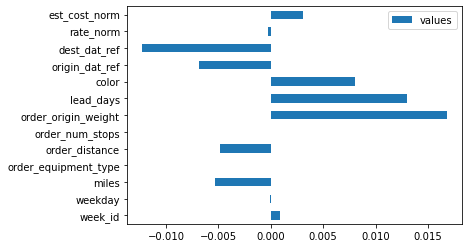

In [42]:
ax = Table_gnb.plot.barh(x='names', y='values')
ax.set_ylabel(None)

In [50]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(gnb, X, y, cv=3))

[0.57238688 0.48224473 0.55677785]


This classification model is correct 53.73% of the time about the condition of a load. I would not recommend this model to predict the status of a load, seeing that it just barely over 50%. The most important features of this model are the shipment weight and the number of days before pickup date that the customer placed the order. Because of the error rate, we cannot confirm if these would even be the best features to use. This model is very overfit becasue of the large difference in mean scores. This model overall needs to be refit to be of more use. 

# Context and Critical Reflection

### I have a few questions about this dataset that would have helped me to understand this analysis further. Who assigns the color of the order, is it automatic or manual (up for interpretation)? Does the type of truck requested rely on the weight of the load?

In order to answer these questions, I would look to ask the team that assigns the color, possibly the vendor? I would aslo seek out who chooses the trucks for each load and determine if there is a cut off weight to choose equipment types. 